#  Flood Monitoring display demonstrator

This inference display notebook is here to show interactively already infered flooded areas with the FloodML Random Forest algorithm. We focused on the Sentinel-1 inferences, as they represent the immense majority of inferences that have been done and studied in the frame of the FloodML project. Four cases can be shown here:

  * EMSR 267 in Lituania, tile 34UEG, date 20180202, orbit DES_051
  * EMSR 271 in Greece, tile 34SEJ, date 20180228, orbit DES_080
  * EMSR 279 in Spain, tile 30TXM, date 20180413, orbit ASC_030
  * EMSR 352 in Iran, tile 39RTQ, date 20190408, orbit DES_108

For the purpose of this notebook the inferences listed previously, originally projected in UTM coordinates, have been projected in EPSG:4326 coordinates (WGS84), in order to display them in folium properly. A similar procss has been applied to GSWO tiles. Along with the flood estimation, we can display the permanent water from the GSWO product by choosing a threshold on the occurrence for the folium interactive map. This threshold can be changed if wanted in the setting of the following variables.

To display one of these inferences in this notebook, please fill properly the variables in the next cell.

BEWARE: the static display might not work if you are not on a 4-core and 15Gb Kernel.

In [1]:
tile = "34SEJ" # String containing the Sentinel-2 tile number 
date = "20180228" # String of the chosen date
orbit = "DES_080" # String of the chosen orbit
thresh = 60 # int/float for the thresholding of water occurrences in GSWO product. 60 is set as default 

print('Tile ref: ', tile)
print('Date : ', date)
print('Orbit : ', orbit)

# Configuration file
pconf = 'config.json' 

Tile ref:  34SEJ
Date :  20180228
Orbit :  DES_080


##  Loading of libraries

In [2]:
import os
import sys
import glob as glob
from IPython.display import display
import numpy as np
import rasterio 
sys.path.append("/home/akynos/AnacondaProjects36/floodml")
import Demo_tools as dtool
conf = dtool.applyconf(pconf)
root_dir = conf['root_dir']
sys.path.append(conf['pykic'])
import raster.pykic_gdal as rpg

## Inference image loading

In [3]:
inf_dir = os.path.join(root_dir, 'INFERENCES')

#On charge me produit tif projeté en WGS84
file = glob.glob(os.path.join(inf_dir,"Inference_RDF_S1_T"+tile+"_"+date+"_"+orbit+"_NOFILT_0_01nan_WGS84.tif"))[0]
infile = os.path.join(inf_dir, file)
print('File to display: ', infile.split('/')[-1])

epsg = rpg.geoinfo(infile, onlyepsg=True)
print('EPSG: ', epsg)

extent = rpg.getextent(infile)
lon_mean = float(np.mean(extent[0:2]))
lat_mean = float(np.mean(extent[2:4]))

src = rasterio.open(infile)
array = src.read()

File to display:  Inference_RDF_S1_T34SEJ_20180228_DES_080_NOFILT_0_01nan_WGS84.tif
EPSG:  4326


## Extraction of permanent water mask from GSWO data

In [4]:
GSWO_dir = os.path.join(root_dir, 'Ancillary', 'GSWO')
gswo_name = os.path.join(GSWO_dir, tile+".tif")

epsg = rpg.geoinfo(os.path.join(gswo_name), onlyepsg=True)
 
gswo, proj, dim, tr = rpg.gdal2array(gswo_name)
mask_gswo=np.zeros(shape=(dim[1], dim[0]))
mask_gswo[np.where((gswo >= thresh))] = 1
mask_gswo[np.where((gswo < thresh))] = 0
print(thresh)
print(gswo_name)
print(infile)


60
/home/akynos/Downloads/phase-2-cls/Demonstrator/Ancillary/GSWO/34SEJ.tif
/home/akynos/Downloads/phase-2-cls/Demonstrator/INFERENCES/Inference_RDF_S1_T34SEJ_20180228_DES_080_NOFILT_0_01nan_WGS84.tif


##  Interactive map creation

In [7]:
import folium

m = folium.Map([lat_mean, lon_mean], zoom_start=8.5)

lgd_txt = '<span style="color: {col};">{txt}</span>'

## Flooded areas feature creation
fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Flooded areas', col= 'Red'))
flood = folium.raster_layers.ImageOverlay(
    image=array[0],
    bounds=[[extent[2], extent[0]], [extent[3], extent[1]]],
    colormap=lambda x: (1, 0, 0, x),
    mercator_project = 1,
)

## Permanent water areas feature creation
fg2 = folium.FeatureGroup(name= lgd_txt.format( txt= 'Permanent water', col= 'Blue'))
perm = folium.raster_layers.ImageOverlay(
    image=mask_gswo,
    bounds=[[extent[2], extent[0]], [extent[3], extent[1]]],
    colormap=lambda x: (0, 0, 1, x),
    mercator_project = 1,
    opacity=0.7,
)


##  Add tile borders
fg3 = folium.FeatureGroup(name= lgd_txt.format( txt= 'Tile %s extent' % tile, col= 'Black'))
t_extent = folium.PolyLine( ([extent[2],extent[0]], 
                  [extent[2],extent[1]], 
                  [extent[3],extent[1]], 
                  [extent[3],extent[0]], 
                  [extent[2],extent[0]]),
                  color="black", weight=1, opacity=1)

fg.add_child(flood)
fg2.add_child(perm)
fg3.add_child(t_extent)

m.add_child( fg)
m.add_child( fg2)
m.add_child( fg3)

folium.map.LayerControl('topleft', collapsed= False).add_to(m)

## Final map display in notebook
m


##  Static display

This step produces a png file which show the selected tile with the estimated flood area with the FloodML RF algorithm, along with permanent waters (GSW occurrences >60%).

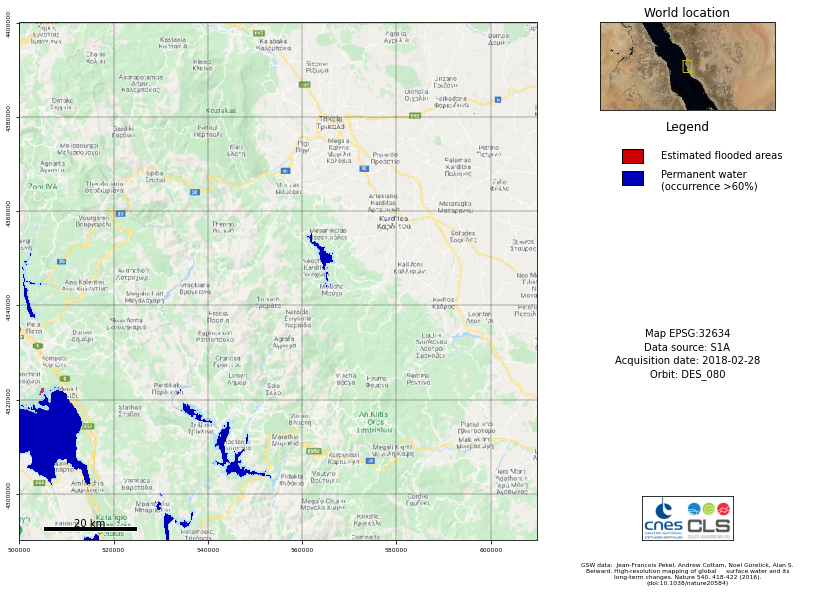

Static display over


In [6]:
file = glob.glob(os.path.join(root_dir, 'INFERENCES',"Inference_RDF_S1_T"+tile+"_"+date+"_"+orbit+"_NOFILT_0_01nan.tif"))[0]
infile = os.path.join(inf_dir, file)

import Demo_tools as dtool
dtool.static_display(infile, tile, date, orbit, root_dir)